# MSI 데이터 처리 파이프라인

이 노트북은 `main.py`, `aggregate.py`, 그리고 `analysis.py` 스크립트를 순차적으로 실행하여 전체 데이터 처리 파이프라인을 실행합니다. </br>
**전제 조건:** </br>
`config`, `data`, `output`, `src` 폴더가 이 노트북과 동일한 디렉토리에 있어야 합니다. </br>
`config.yaml`에 정의된 `data_dir`에 원본 `.imzML` 파일들이 준비되어 있어야 합니다. </br>

In [1]:
# 분석에 사용할 config 파일 경로를 여기서 지정합니다.
# 예: 'config/config_experiment_A.yaml', 'config/config_experiment_B.yaml'
CONFIG_PATH = 'config/config.yaml'

In [2]:
import sys
import os

# 'src' 폴더를 Python의 모듈 검색 경로에 추가합니다.
if 'src' not in sys.path:
    sys.path.append('src')
    print("'src' 폴더를 시스템 경로에 추가했습니다.")

'src' 폴더를 시스템 경로에 추가했습니다.


In [3]:
import src.main as main
import src.aggregate as aggregate
import src.parsing as parsing
import src.analysis as analysis
import pandas as pd
from IPython.display import display, Image

## 1단계: .imzML 파일 파싱 및 개별 CSV 생성

`main.py`는 `config.yaml`을 읽고, 파일 유효성을 검사한 뒤, 모든 `.imzML` 파일을 파싱하여 `output_dir`에 개별 `..._mean_intensities.csv` 파일을 저장합니다.

In [4]:
main.main(config_path=CONFIG_PATH)

--- 1. 설정 파일 로드 ---

--- 2. m/z 빈(Bin) 정보 로드 ---
m/z bin load 모드: 'file'
'config/Mass ranges of molecules.csv' 파일에서 m/z bin 목록을 로드합니다.
총 7개의 m/z bin을 로드했습니다.

--- 3. 처리할 파일 목록 생성 ---

--- 파일 유효성 검사 (총 24개) ---
성공: 모든 예상 파일 24개를 data_dir에서 확인했습니다.

--- 4. 총 24개 파일 처리 시작 ---

--- [ 1 / 24 ] ---

파일 열기 성공: data/4_groups\saline 1-1 cortex-total ion count.imzML
총 스펙트럼 수: 1052
적용할 m/z 빈(컬럼) 수: 7
1단계: 각 스펙트럼을 마스터 m/z bin에 정렬하는 중...
  ... 1000 / 1052 스펙트럼 처리 완료
  ... 1052 / 1052 스펙트럼 처리 완료
데이터 정렬 완료.
2단계: CSV 파일 생성 중...

Binned Intensity 매트릭스 저장 완료: output/4_groups\saline 1-1 cortex-total ion count_binned_spectra.csv
  - 형태: (1052, 9)
평균 Intensity 저장 완료: output/4_groups\saline 1-1 cortex-total ion count_mean_intensities.csv
  - 형태: (1, 7)

--- [ 2 / 24 ] ---

파일 열기 성공: data/4_groups\saline 1-2 cortex-total ion count.imzML
총 스펙트럼 수: 1050
적용할 m/z 빈(컬럼) 수: 7
1단계: 각 스펙트럼을 마스터 m/z bin에 정렬하는 중...
  ... 1000 / 1050 스펙트럼 처리 완료
  ... 1050 / 1050 스펙트럼 처리 완료
데이터 정렬 완료.
2단계: CSV 파일 생성 중...

Binned Intensi

## 2단계: 개별 CSV 집계

`aggregate.py`는 `output_dir`의 `..._mean_intensities.csv` 파일들을 읽어와 `num_serial` 기준으로 평균을 내고, 최종 집계 파일인 `aggregated_mean_intensities.csv`를 저장합니다.

In [5]:
aggregate.main(config_path=CONFIG_PATH)

--- 1. 설정 파일 로드 ---
'output/4_groups' 디렉토리에서 '_mean_intensities.csv' 파일들을 집계합니다.

--- 2. 총 48개 조합(group*n*roi) 집계 시도 ---
m/z 빈(컬럼) 7개 확인: 72.9926...
  -> 처리 완료: saline 1 cortex (파일 2개 평균)
  -> 처리 완료: saline 2 cortex (파일 2개 평균)
  -> 처리 완료: saline 3 cortex (파일 2개 평균)
  -> 처리 완료: glyoxylate 1 cortex (파일 2개 평균)
  -> 처리 완료: glyoxylate 2 cortex (파일 2개 평균)
  -> 처리 완료: glyoxylate 3 cortex (파일 2개 평균)
  -> 처리 완료: acetate 1 cortex (파일 2개 평균)
  -> 처리 완료: acetate 2 cortex (파일 2개 평균)
  -> 처리 완료: acetate 3 cortex (파일 2개 평균)
  -> 처리 완료: etoh 1 cortex (파일 2개 평균)
  -> 처리 완료: etoh 2 cortex (파일 2개 평균)
  -> 처리 완료: etoh 3 cortex (파일 2개 평균)

--- 집계가 완료되었습니다. ---
최종 집계 데이터 (형태: (12, 10))가 다음 파일에 저장되었습니다:
output/4_groups\aggregated_mean_intensities.csv


## 3단계: 통계 분석 및 시각화

`analysis.py`는 `aggregated_mean_intensities.csv` 파일을 읽어 Long-format으로 변환하고, `config.yaml`의 설정에 따라 통계 분석(t-test/ANOVA 또는 Mann-Whitney/Kruskal) 및 Post-hoc 검정을 수행합니다. </br>
결과는 `statistical_results_main.csv`, `statistical_results_posthoc.csv` 두 개의 파일과 ROI별 플롯(예: `plot_roi_cortex.png`)으로 `output_dir`에 저장됩니다.

--- 1. 설정 파일 로드 ---
--- 2. 집계 데이터 로드 ---
데이터를 Long format으로 변환 (총 84 행)

--- 3. ROI 1개에 대한 분석 시작 ---

분석 중인 ROI: cortex
  -> 몽타주 플롯 생성 중: cortex
  -> 몽타주 플롯 생성 중: cortex
  -> 몽타주 플롯 저장 완료: output/4_groups\plot_montage_roi_cortex.png
  -> Prism용 CSV 파일 생성 중: cortex
  -> Prism 파일 저장 완료: output/4_groups\aggregated_data_roi_cortex_prism.csv

--- 4. 통계 결과 저장 ---
메인 통계 결과 저장 완료: output/4_groups\statistical_results_main.csv
Post-hoc 통계 결과 저장 완료: output/4_groups\statistical_results_posthoc.csv

--- HTML 보고서 생성 시작 ---
HTML report generated: output/4_groups\analysis_report.html

--- 모든 분석 및 시각화가 완료되었습니다. ---


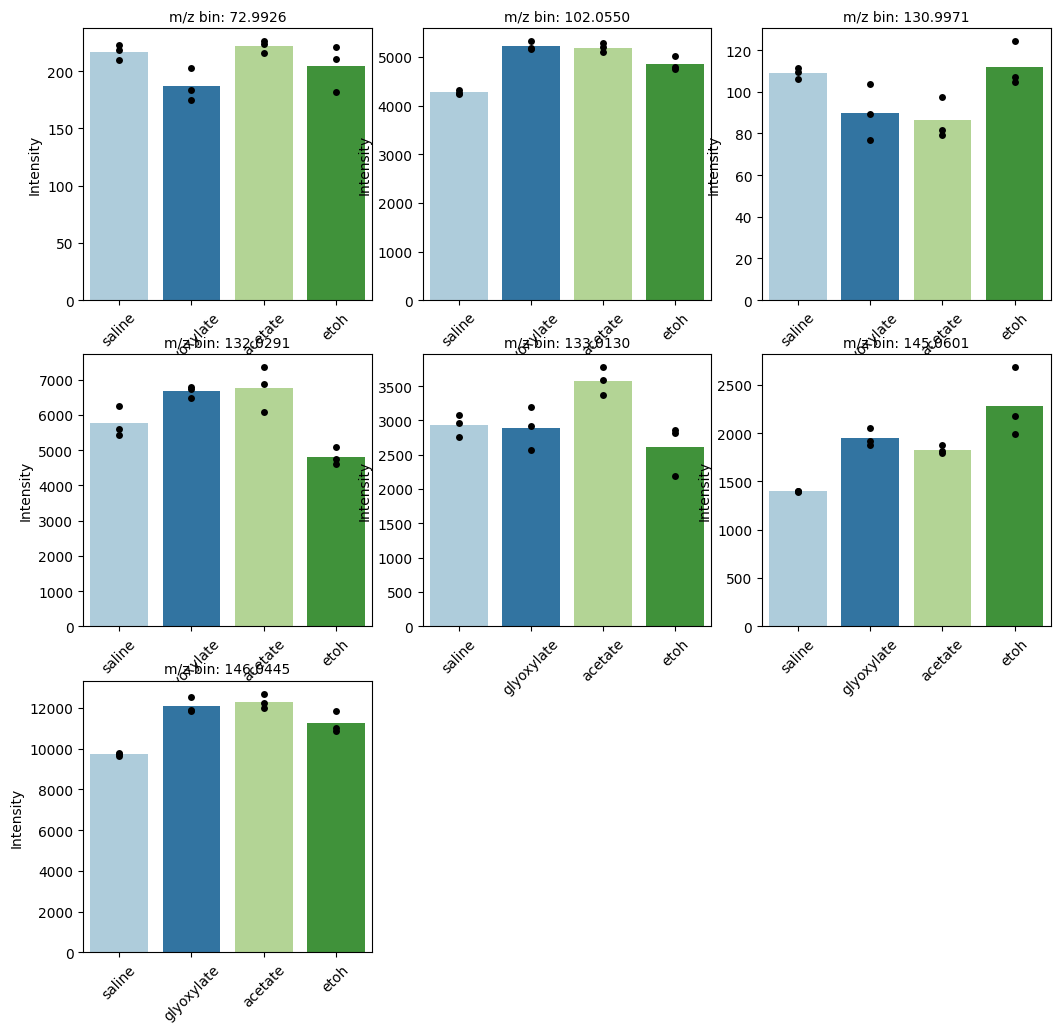

In [6]:
analysis.main(config_path=CONFIG_PATH)

## 4단계: 집계 결과 확인

2단계의 최종 집계물인 `aggregated_mean_intensities.csv` 파일을 로드하여 확인합니다.

In [7]:
# config 파일 경로를 'config/config.yaml'로 명확히 지정합니다
config_path = 'config/config.yaml'
config = parsing.load_yaml(config_path)

if config and 'output_dir' in config:
    output_dir = config['output_dir']
    final_csv_path = os.path.join(output_dir, "aggregated_mean_intensities.csv")
    if os.path.exists(final_csv_path):
        df_final = pd.read_csv(final_csv_path)
        print(f"{final_csv_path}' 파일 로드 성공.")
        print(f"최종 데이터 형태: {df_final.shape}")
        # Jupyter Notebook 환경에서는 display()가 더 깔끔하게 출력됩니다.\n",
        display(df_final)
    else:
        print(f"오류: 최종 결과 파일 '{final_csv_path}'을(를) 찾을 수 없습니다.")
else:
    print(f"오류: '{config_path}'에서 'output_dir'을 찾을 수 없습니다.")

output/4_groups\aggregated_mean_intensities.csv' 파일 로드 성공.
최종 데이터 형태: (12, 10)


,group,n,roi,72.9926,102.0550,130.9971,132.0291,133.0130,145.0601,146.0445
0,saline,1,cortex,209.3453,4257.0637,109.2511,5594.9734,2752.3290,1393.7934,9799.4394
1,saline,2,cortex,218.4692,4327.8401,111.5675,5444.0547,2964.2141,1404.4593,9714.4268
2,saline,3,cortex,223.2434,4234.1331,105.8931,6249.3516,3083.6885,1400.5141,9654.6655
3,glyoxylate,1,cortex,202.4357,5323.1926,103.5192,6800.7231,3195.2553,2056.6910,12532.0630
4,glyoxylate,2,cortex,175.0095,5156.4922,76.6226,6735.7321,2570.5293,1914.3004,11917.5869
5,glyoxylate,3,cortex,183.5174,5175.9201,89.1753,6470.0940,2921.0847,1879.9822,11841.2837
6,acetate,1,cortex,216.2555,5290.5845,97.5378,7349.7888,3372.9815,1877.2203,12700.7334
7,acetate,2,cortex,223.5016,5196.8174,81.8250,6093.5242,3594.5593,1794.9183,12217.4932
8,acetate,3,cortex,226.0931,5097.6480,79.4107,6884.9971,3771.1333,1809.6653,11981.7774
9,etoh,1,cortex,181.9409,4794.7080,104.7416,5103.1236,2184.0832,2679.2186,10848.7378


## 5단계: 통계 분석 결과 확인

3단계에서 생성된 통계 결과(Post-hoc 기준)와 생성된 플롯을 확인합니다.

'output/4_groups\statistical_results_posthoc.csv' 파일 로드 성공.
Post-hoc 통계 데이터 형태: (30, 8)


,roi,m_z_bin,test_name,group1,group2,p_value,p_adj,significant
0,cortex,102.0550,Mann-Whitney (Bonferroni),saline,glyoxylate,0.1,0.6,False
1,cortex,102.0550,Mann-Whitney (Bonferroni),saline,acetate,0.1,0.6,False
2,cortex,102.0550,Mann-Whitney (Bonferroni),saline,etoh,0.1,0.6,False
3,cortex,102.0550,Mann-Whitney (Bonferroni),glyoxylate,acetate,1.0,1.0,False
4,cortex,102.0550,Mann-Whitney (Bonferroni),glyoxylate,etoh,0.1,0.6,False
5,cortex,102.0550,Mann-Whitney (Bonferroni),acetate,etoh,0.1,0.6,False
6,cortex,130.9971,Mann-Whitney (Bonferroni),saline,glyoxylate,0.1,0.6,False
7,cortex,130.9971,Mann-Whitney (Bonferroni),saline,acetate,0.1,0.6,False
8,cortex,130.9971,Mann-Whitney (Bonferroni),saline,etoh,1.0,1.0,False
9,cortex,130.9971,Mann-Whitney (Bonferroni),glyoxylate,acetate,1.0,1.0,False


--- 생성된 몽타주 플롯 확인 ---
output/4_groups\plot_montage_roi_cortex.png 에서 생성된 몽타주 플롯:


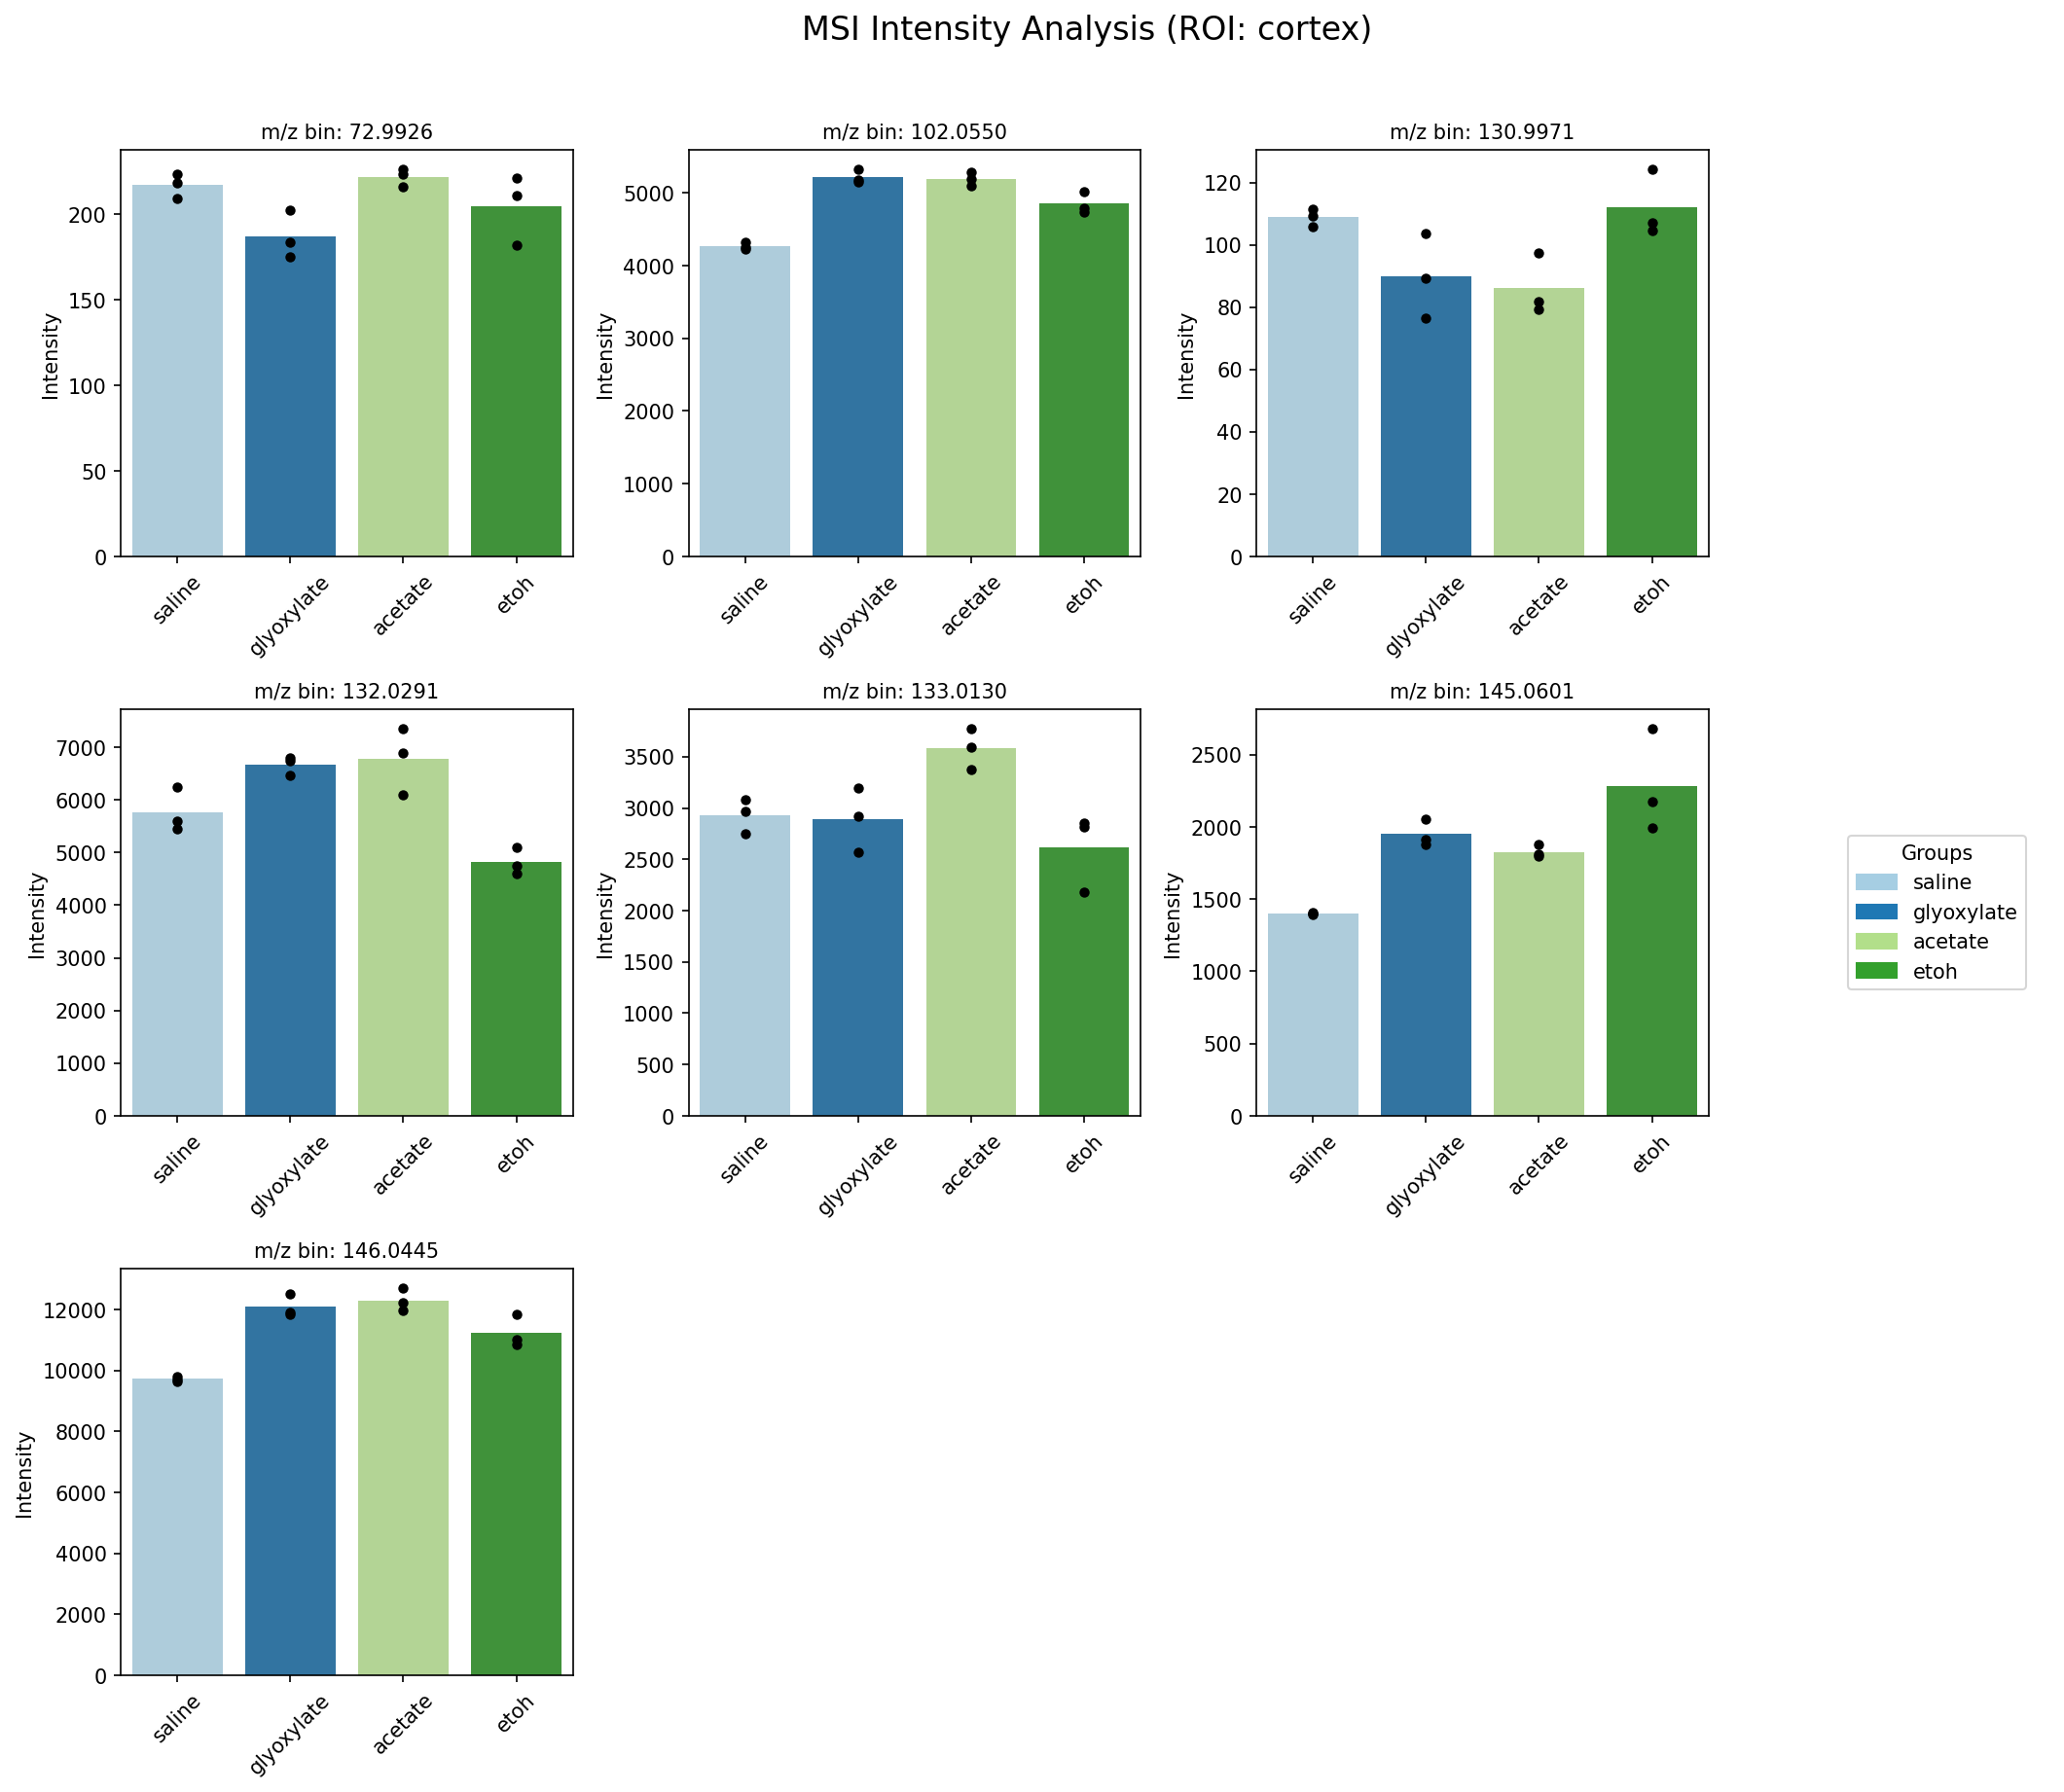

In [8]:
if config and 'output_dir' in config:
    output_dir = config['output_dir']
    stats_csv_path = os.path.join(output_dir, "statistical_results_posthoc.csv")
    if os.path.exists(stats_csv_path):
        df_stats = pd.read_csv(stats_csv_path)
        print(f"'{stats_csv_path}' 파일 로드 성공.")
        print(f"Post-hoc 통계 데이터 형태: {df_stats.shape}")
    # 유의미한(significant=True) 결과만 필터링하여 확인
        display(df_stats)
    else:
        print(f"오류: 통계 결과 파일 '{stats_csv_path}'을(를) 찾을 수 없습니다.")
print("--- 생성된 몽타주 플롯 확인 ---")
# config의 roi 정보로 생성된 플롯 파일명 추정",
if 'roi_info' in config:
    for roi_dict in config['roi_info']:
        roi_name = roi_dict['name']
        plot_path = os.path.join(output_dir, f"plot_montage_roi_{roi_name}.png")
        if os.path.exists(plot_path):
            print(f"{plot_path} 에서 생성된 몽타주 플롯:")
            display(Image(filename=plot_path, width=800))
        else:
            print(f"오류: 플롯 파일 '{plot_path}'을(를) 찾을 수 없습니다.")
else:
    print("오류: 'config.yaml'에서 'output_dir'을 찾을 수 없습니다.")